In [1]:
import os                       # for working with files

import torch                    # Pytorch module 
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision import datasets,transforms,models   # for working with classes and images

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
data_dir = "C:\code\Project_TTKH\Data"
train_dir = os.path.join(data_dir,"train")
diseases = os.listdir(train_dir)
diseases

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Admin\AppData\Local\Temp\ipykernel_24192\1993482742.py:1: SyntaxWarning: invalid escape sequence '\c'
  data_dir = "C:\code\Project_TTKH\Data"


['COVID', 'non-COVID']

In [3]:
batch_size = 12
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.Grayscale()
    ]),
    'Test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.Grayscale()
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['Train', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Test']}
class_names = image_datasets['Train'].classes
print(class_names)

['COVID', 'non-COVID']


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model = torch.load('Model/full_models.pt')
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [6]:
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
y_true=[]
model.eval()
with torch.inference_mode():
  for X, y in tqdm(dataloaders["Test"], desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
    y_true.append(y.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_true)

Making predictions:   0%|          | 0/42 [00:00<?, ?it/s]

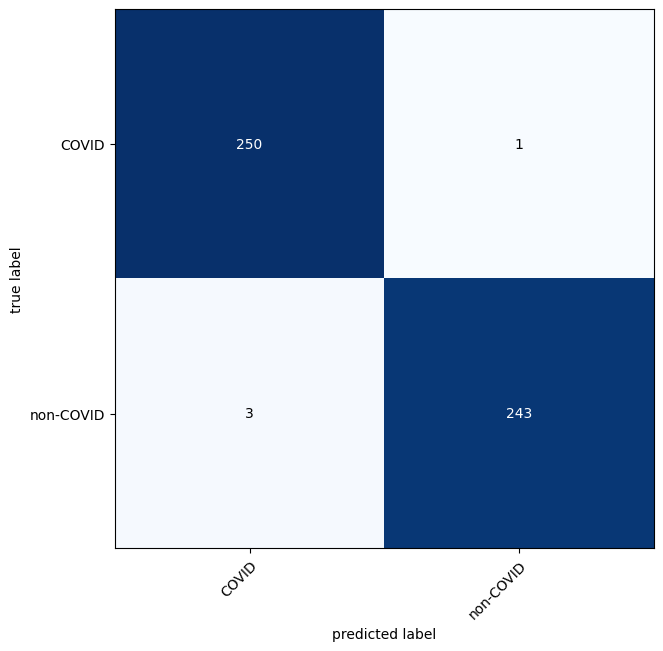

In [7]:
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_true_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), 
    class_names=class_names, 
    figsize=(10, 7)
)

In [8]:
y_pred_np = y_pred_tensor.numpy()
y_true_np = y_true_tensor.numpy()

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(y_true_np, y_pred_np)
precision = precision_score(y_true_np, y_pred_np)
recall = recall_score(y_true_np, y_pred_np)
f1 = f1_score(y_true_np, y_pred_np)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9920
Precision: 0.9959
Recall: 0.9878
F1 Score: 0.9918
